# 神经网络作业 - 预训练模型微调

## 实验过程

### 准备阶段
首先导入必要的库

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy

定义数据预处理和加载数据集

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.RandomErasing(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

extract_path = './dataset/101_ObjectCategories'
dataset = datasets.ImageFolder(root=extract_path, transform=train_transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### 加载预训练模型并修改分类层

In [ ]:
def create_model(num_classes, fine_tune=True):
    model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    
    # Freeze all parameters
    if fine_tune:
        for param in model.parameters():
            param.requires_grad = False
            
        # Unfreeze the last few layers
        for param in model.features[-4:].parameters():
            param.requires_grad = True
    
    model.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(True),
        nn.Dropout(p=0.5),
        nn.Linear(4096, 2048),
        nn.ReLU(True),
        nn.Dropout(p=0.5),
        nn.Linear(2048, num_classes)
    )
    
    return model

### 定义训练和评估函数

In [ ]:
def train_model(num_epochs, model, criterion, optimizer, scheduler, train_loader, val_loader, device, patience=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    patience_counter = 0
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc='Training'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100 * running_corrects / total
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.2f}%')

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc='Validation'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                running_corrects += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss = running_loss / len(val_loader.dataset)
        val_acc = 100 * running_corrects / total
        
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.2f}%')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping triggered after epoch {epoch+1}')
            break

        scheduler.step(val_loss)

    # Load best model weights
    model.load_state_dict(best_model_wts)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += (predicted == labels).sum().item()
            total += labels.size(0)

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = 100 * running_corrects / total
    
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

### 开始训练

使用预训练模型进行微调

C:\Users\lenovo\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50
----------


Training: 100%|██████████| 200/200 [01:12<00:00,  2.77it/s]


Training Loss: 1.5620 Acc: 65.06%


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]


Validation Loss: 0.4805 Acc: 86.76%
Epoch 2/50
----------


Training: 100%|██████████| 200/200 [01:13<00:00,  2.74it/s]


Training Loss: 0.3079 Acc: 92.16%


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.64it/s]


Validation Loss: 0.3751 Acc: 90.04%
Epoch 3/50
----------


Training: 100%|██████████| 200/200 [01:13<00:00,  2.73it/s]


Training Loss: 0.0824 Acc: 98.17%


Validation: 100%|██████████| 15/15 [00:08<00:00,  1.67it/s]


Validation Loss: 0.3305 Acc: 89.93%
Epoch 4/50
----------


Training: 100%|██████████| 200/200 [01:13<00:00,  2.71it/s]


Training Loss: 0.0621 Acc: 98.78%


Validation: 100%|██████████| 15/15 [00:08<00:00,  1.69it/s]


Validation Loss: 0.3435 Acc: 92.01%
Epoch 5/50
----------


Training: 100%|██████████| 200/200 [01:13<00:00,  2.73it/s]


Training Loss: 0.0310 Acc: 99.53%


Validation: 100%|██████████| 15/15 [00:08<00:00,  1.69it/s]


Validation Loss: 0.3375 Acc: 91.25%
Epoch 6/50
----------


Training: 100%|██████████| 200/200 [01:13<00:00,  2.72it/s]


Training Loss: 0.0279 Acc: 99.45%


Validation: 100%|██████████| 15/15 [00:08<00:00,  1.67it/s]


Validation Loss: 0.3865 Acc: 89.50%
Epoch 7/50
----------


Training: 100%|██████████| 200/200 [01:13<00:00,  2.73it/s]


Training Loss: 0.0378 Acc: 99.05%


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]


Validation Loss: 0.4057 Acc: 90.26%
Epoch 8/50
----------


Training: 100%|██████████| 200/200 [01:13<00:00,  2.73it/s]


Training Loss: 0.0151 Acc: 99.75%


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]


Validation Loss: 0.3461 Acc: 90.92%
Epoch 9/50
----------


Training: 100%|██████████| 200/200 [01:13<00:00,  2.72it/s]


Training Loss: 0.0090 Acc: 99.89%


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]


Validation Loss: 0.3269 Acc: 91.03%
Epoch 10/50
----------


Training: 100%|██████████| 200/200 [01:13<00:00,  2.72it/s]


Training Loss: 0.0089 Acc: 99.92%


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]


Validation Loss: 0.3209 Acc: 91.47%
Epoch 11/50
----------


Training: 100%|██████████| 200/200 [01:13<00:00,  2.72it/s]


Training Loss: 0.0065 Acc: 99.91%


Validation: 100%|██████████| 15/15 [00:08<00:00,  1.69it/s]


Validation Loss: 0.3168 Acc: 91.36%
Epoch 12/50
----------


Training: 100%|██████████| 200/200 [01:13<00:00,  2.72it/s]


Training Loss: 0.0039 Acc: 99.91%


Validation: 100%|██████████| 15/15 [00:08<00:00,  1.68it/s]


Validation Loss: 0.3181 Acc: 91.36%
Epoch 13/50
----------


Training: 100%|██████████| 200/200 [01:13<00:00,  2.73it/s]


Training Loss: 0.0032 Acc: 99.97%


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]


Validation Loss: 0.3130 Acc: 91.68%
Epoch 14/50
----------


Training: 100%|██████████| 200/200 [01:13<00:00,  2.72it/s]


Training Loss: 0.0055 Acc: 99.95%


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]


Validation Loss: 0.3114 Acc: 91.47%
Epoch 15/50
----------


Training: 100%|██████████| 200/200 [01:13<00:00,  2.74it/s]


Training Loss: 0.0036 Acc: 99.91%


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.64it/s]


Validation Loss: 0.3105 Acc: 91.47%
Epoch 16/50
----------


Training: 100%|██████████| 200/200 [01:13<00:00,  2.73it/s]


Training Loss: 0.0045 Acc: 99.91%


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.64it/s]


Validation Loss: 0.3125 Acc: 91.58%
Epoch 17/50
----------


Training: 100%|██████████| 200/200 [01:13<00:00,  2.72it/s]


Training Loss: 0.0029 Acc: 99.95%


Validation: 100%|██████████| 15/15 [00:08<00:00,  1.69it/s]


Validation Loss: 0.3095 Acc: 91.90%
Epoch 18/50
----------


Training: 100%|██████████| 200/200 [01:13<00:00,  2.73it/s]


Training Loss: 0.0024 Acc: 99.94%


Validation: 100%|██████████| 15/15 [00:08<00:00,  1.70it/s]


Validation Loss: 0.3146 Acc: 92.01%
Epoch 19/50
----------


Training: 100%|██████████| 200/200 [01:12<00:00,  2.75it/s]


Training Loss: 0.0044 Acc: 99.92%


Validation: 100%|██████████| 15/15 [00:08<00:00,  1.71it/s]


Validation Loss: 0.3068 Acc: 92.12%
Epoch 20/50
----------


Training: 100%|██████████| 200/200 [01:13<00:00,  2.74it/s]


Training Loss: 0.0017 Acc: 99.95%


Validation: 100%|██████████| 15/15 [00:08<00:00,  1.67it/s]


Validation Loss: 0.3050 Acc: 92.01%
Epoch 21/50
----------


Training: 100%|██████████| 200/200 [01:13<00:00,  2.72it/s]


Training Loss: 0.0021 Acc: 99.97%


Validation: 100%|██████████| 15/15 [00:08<00:00,  1.68it/s]


Validation Loss: 0.2970 Acc: 92.45%
Epoch 22/50
----------


Training: 100%|██████████| 200/200 [01:13<00:00,  2.72it/s]


Training Loss: 0.0019 Acc: 99.95%


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]


Validation Loss: 0.2935 Acc: 92.12%
Epoch 23/50
----------


Training: 100%|██████████| 200/200 [01:13<00:00,  2.74it/s]


Training Loss: 0.0063 Acc: 99.91%


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.63it/s]


Validation Loss: 0.2992 Acc: 92.56%
Epoch 24/50
----------


Training: 100%|██████████| 200/200 [01:14<00:00,  2.70it/s]


Training Loss: 0.0050 Acc: 99.94%


Validation: 100%|██████████| 15/15 [00:08<00:00,  1.69it/s]


Validation Loss: 0.3034 Acc: 92.89%
Epoch 25/50
----------


Training: 100%|██████████| 200/200 [01:12<00:00,  2.74it/s]


Training Loss: 0.0024 Acc: 99.94%


Validation: 100%|██████████| 15/15 [00:08<00:00,  1.69it/s]


Validation Loss: 0.2997 Acc: 92.89%
Epoch 26/50
----------


Training: 100%|██████████| 200/200 [01:13<00:00,  2.72it/s]


Training Loss: 0.0026 Acc: 99.95%


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]


Validation Loss: 0.3000 Acc: 92.56%
Epoch 27/50
----------


Training: 100%|██████████| 200/200 [01:13<00:00,  2.71it/s]


Training Loss: 0.0024 Acc: 99.95%


Validation: 100%|██████████| 15/15 [00:08<00:00,  1.68it/s]


Validation Loss: 0.2981 Acc: 92.67%
Epoch 28/50
----------


Training: 100%|██████████| 200/200 [01:13<00:00,  2.72it/s]


Training Loss: 0.0021 Acc: 99.95%


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.62it/s]


Validation Loss: 0.2974 Acc: 92.45%
Epoch 29/50
----------


Training: 100%|██████████| 200/200 [01:15<00:00,  2.66it/s]


Training Loss: 0.0017 Acc: 99.97%


Validation: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]


Validation Loss: 0.2965 Acc: 92.56%
Early stopping triggered after epoch 29


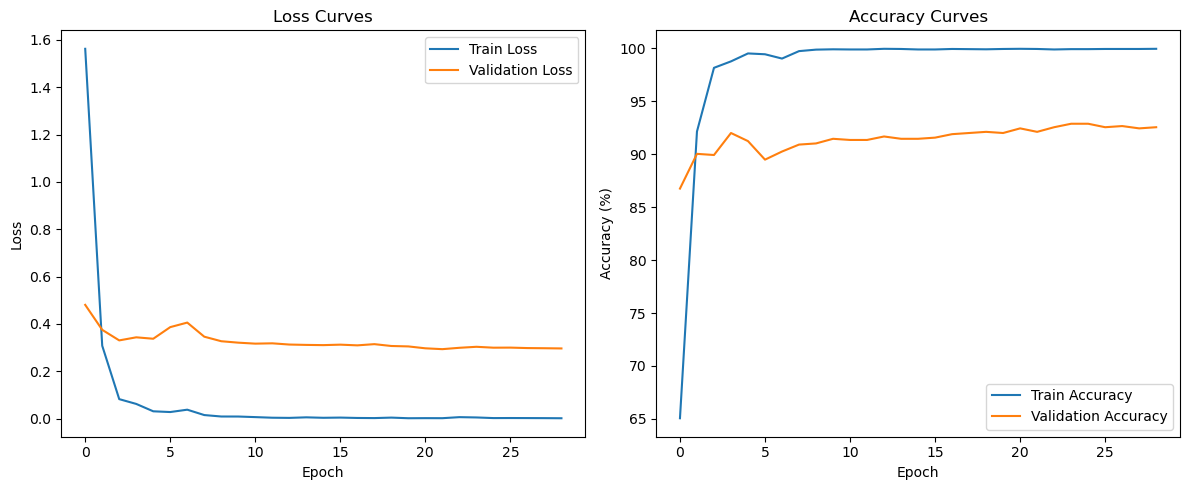

Testing: 100%|██████████| 29/29 [00:18<00:00,  1.56it/s]


Test Loss: 0.3265, Test Accuracy: 92.79%


In [ ]:
# Create model with pretrained weights
num_classes = len(dataset.classes)
model = create_model(num_classes, fine_tune=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()

# Higher learning rate for new layers, lower for fine-tuned layers
params_to_update = [
    {'params': [param for name, param in model.named_parameters() if 'classifier' not in name], 'lr': 2e-5},
    {'params': model.classifier.parameters(), 'lr': 2e-4}
]

optimizer = optim.AdamW(params_to_update, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
epochs = 50
train_model(epochs, model, criterion, optimizer, scheduler, train_loader, val_loader, device, patience=7)
evaluate_model(model, test_loader, criterion, device)
torch.save({
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'fine_tuned_vgg16.pth')

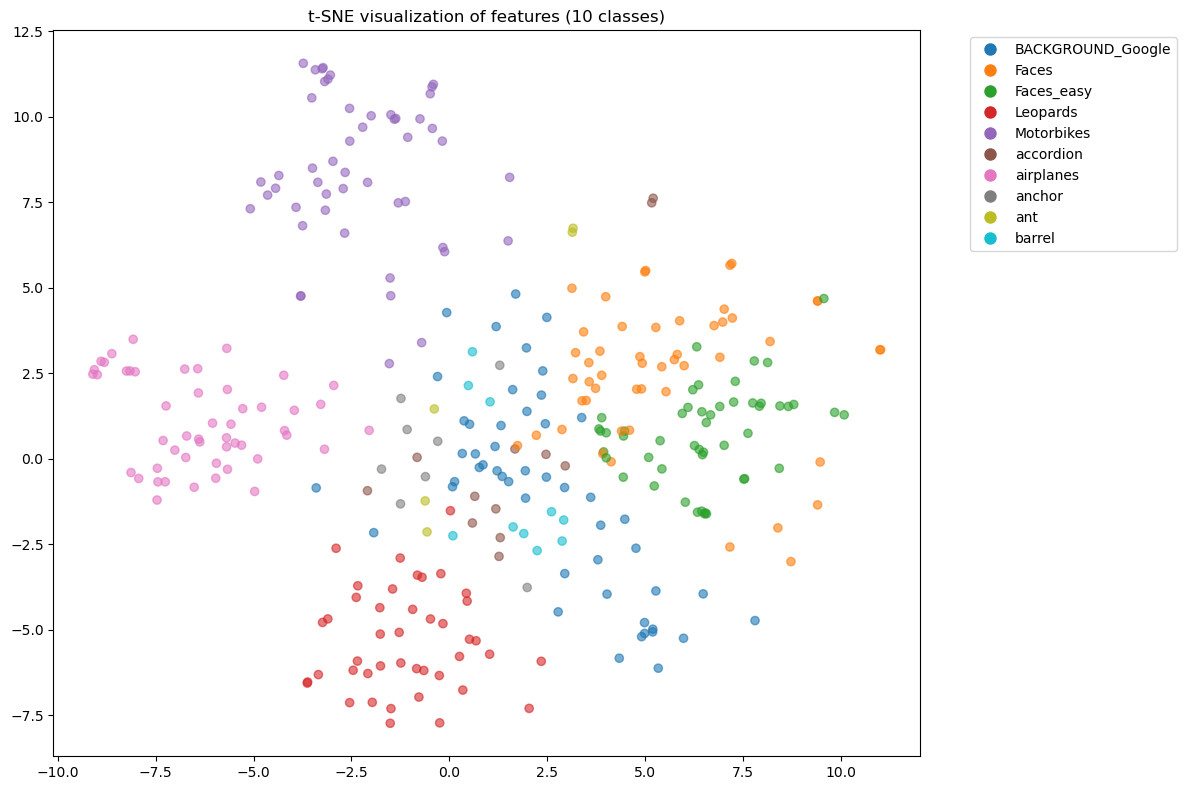

In [ ]:
def get_features(model, dataloader, device, num_classes=10, num_samples=50):
    model.eval()
    features = []
    labels = []
    class_counts = {}
    
    selected_classes = list(dataset.class_to_idx.values())[:num_classes]
    feature_extractor = nn.Sequential(*list(model.features.children()))
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            batch_size = inputs.size(0)
            
            mask = torch.tensor([t.item() in selected_classes for t in targets])
            if not mask.any():
                continue
                
            inputs = inputs[mask]
            targets = targets[mask]
            
            if inputs.size(0) == 0:
                continue
                
            output = feature_extractor(inputs)
            output = output.view(output.size(0), -1)
            
            for i in range(output.size(0)):
                label = targets[i].item()
                if label not in class_counts:
                    class_counts[label] = 0
                if class_counts[label] < num_samples:
                    features.append(output[i].cpu().numpy())
                    labels.append(label)
                    class_counts[label] += 1
            
            # Check if we have collected enough samples for each selected class
            if all(class_counts.get(cls, 0) >= num_samples for cls in selected_classes):
                break
    
    return np.array(features), np.array(labels)

def visualize_tsne(features, labels, class_names, num_classes=10):
    selected_classes = list(sorted(class_names.keys()))[:num_classes]
    mask = np.isin(labels, selected_classes)
    features = features[mask]
    labels = labels[mask]
    
    tsne = TSNE(n_components=2, random_state=42)
    features_embedded = tsne.fit_transform(features)
    
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(features_embedded[:, 0], features_embedded[:, 1], 
                         c=labels, cmap='tab10', alpha=0.6)
    
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=scatter.cmap(scatter.norm(label)), 
                                 label=class_names[label], markersize=10)
                      for label in selected_classes]
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.title('t-SNE visualization of features (10 classes)')
    plt.tight_layout()
    plt.show()

features, labels = get_features(model, test_loader, device, num_classes=10, num_samples=50)
class_names = {v: k for k, v in dataset.class_to_idx.items()}
visualize_tsne(features, labels, class_names, num_classes=10)